### Import data from raw ".csv" file

In [77]:
import numpy as np
import struct

#filename = '../data/PMPM_RAW_BIN_60s_20241023_084401.csv'
filename='../data/PMPM_RAW_BIN_60s_20241030_095308.csv'
print('Reading file:',filename)

# Lire le fichier .csv qui contient le flux de bytes
with open(filename, 'rb') as f:
    byte_stream = f.read()  # Lire tout le fichier comme un flux de bytes
num_values = len(byte_stream) // 2  # Calcul du nombre d'entiers
values = []

for i in range(num_values):
    two_bytes = byte_stream[i*2:(i*2)+2]
    value = struct.unpack('<h', two_bytes)[0]  # '<h' pour 2 bytes en short int
    values.append(value)
print("List created with : {} elements".format(len(values)))
    
npValues=np.array(values, dtype=np.int16)
start_size=1
sound_size=50
accel_size=50
slice_size=start_size+sound_size+accel_size
num_slice = len(npValues)//slice_size # Nombre de tranches

start_indices=np.concatenate([np.arange(i*slice_size, i*slice_size+start_size) for i in range(num_slice)])
sound_indices=np.concatenate([np.arange(i*slice_size+start_size, i*slice_size+sound_size+1) for i in range(num_slice)])
accel_indices=np.concatenate([np.arange(i*slice_size+start_size+sound_size, i*slice_size+slice_size) for i in range(num_slice)])
startValues=npValues[start_indices]
soundValues=npValues[sound_indices]
accelXValues=npValues[accel_indices]

fs=50000
sample_table_size = 50
print("Data classified.\n Number of digital samples is : {}, that is {}s \n Number of sampled sound values : {}, that is {}s \n".format(len(startValues), len(startValues)/(fs/sample_table_size), len(soundValues), len(soundValues)/fs))
print(start_indices[:5])
print(sound_indices[:200])
print(accel_indices[:200])

Reading file: ../data/PMPM_RAW_BIN_60s_20241030_095308.csv
List created with : 6060000 elements
Data classified.
 Number of digital samples is : 60000, that is 60.0s 
 Number of sampled sound values : 3000000, that is 60.0s 

[  0 101 202 303 404]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 3

# Analysis of the acceleration signal measured during 1 minute


Accel in int16 Max Value is 2218, Min Value is -3826
Accel in m/s2 Max Value is 33.200958251953125, Min Value is -57.270904541015625


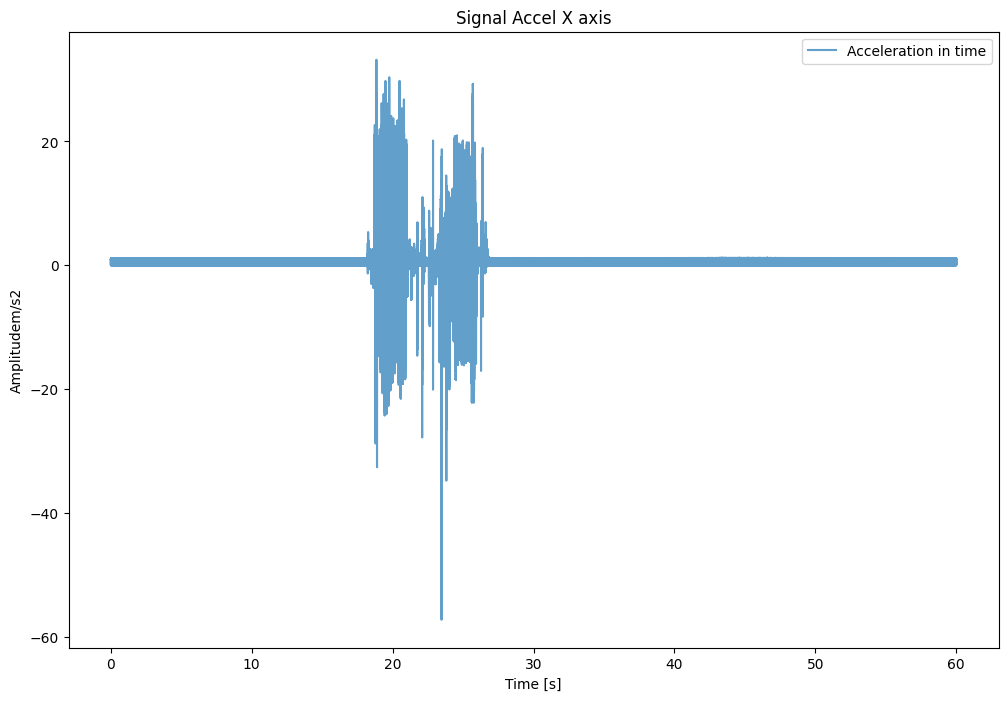

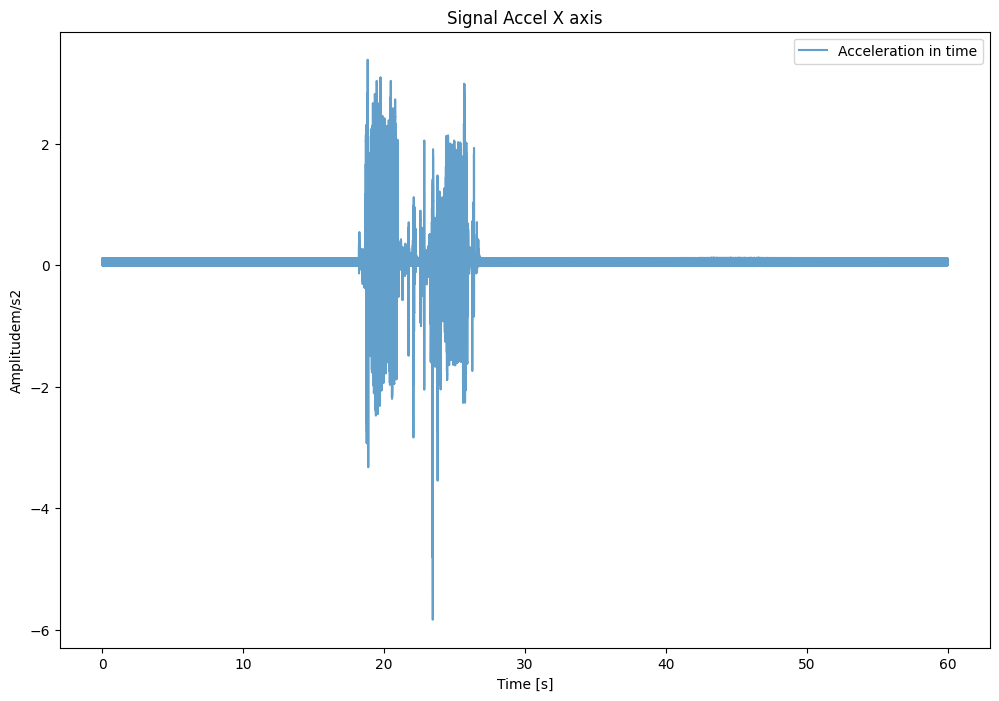

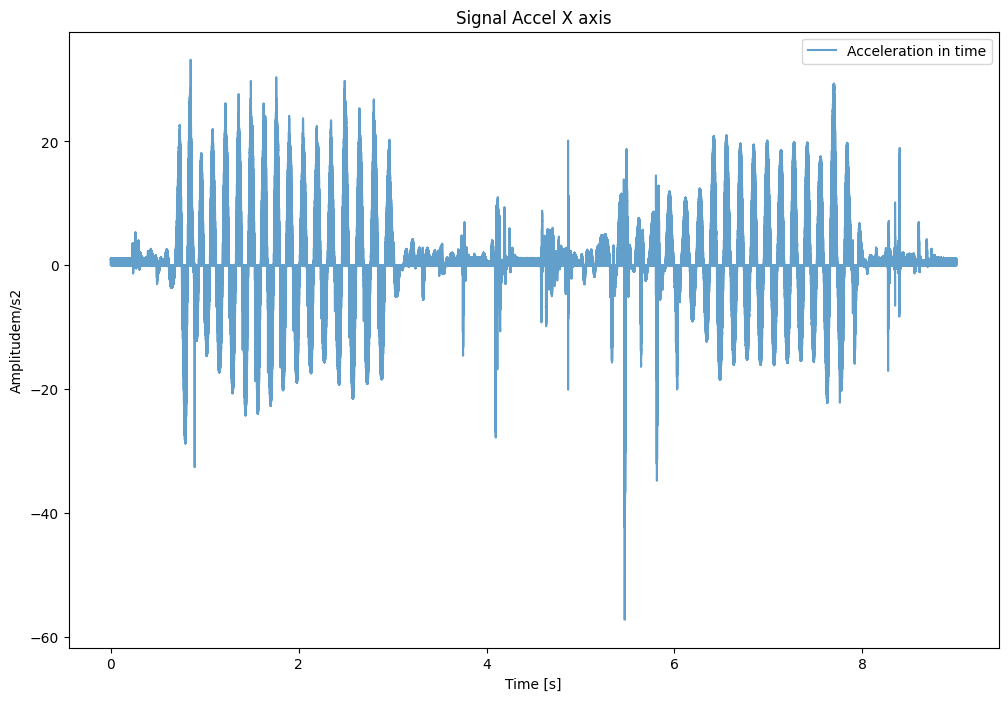

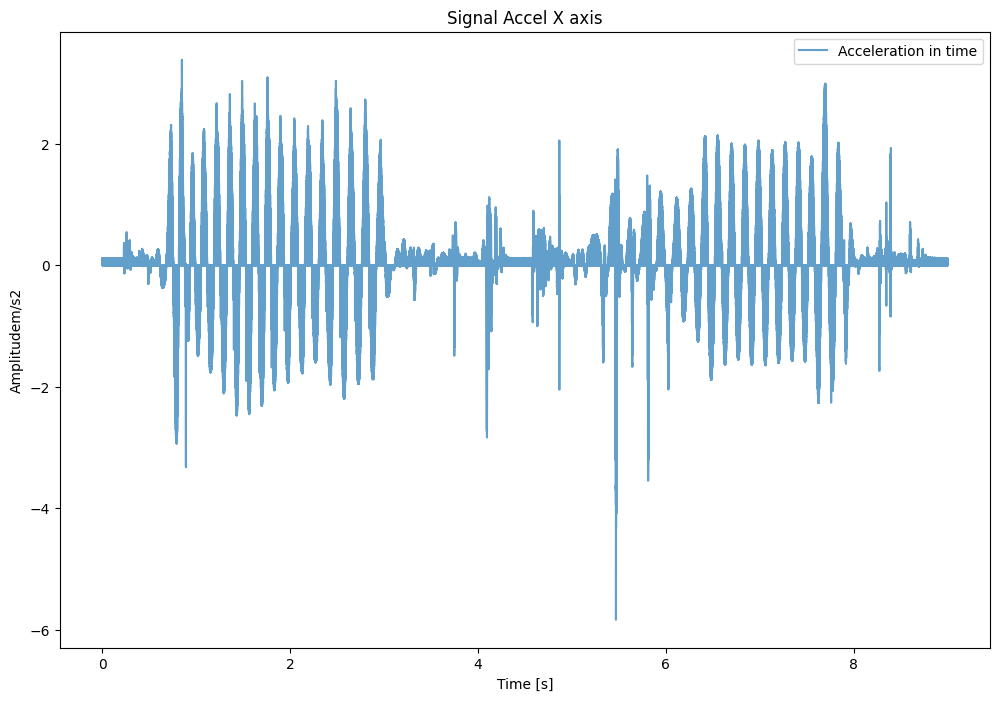

In [92]:
import matplotlib.pyplot as plt
accelValues=accelXValues.copy()
accelValues=accelValues*(50*9.81/(2**15))

print("Accel in int16 Max Value is {}, Min Value is {}".format(np.max(accelXValues), np.min(accelXValues)))
print("Accel in m/s2 Max Value is {}, Min Value is {}".format(np.max(accelValues), np.min(accelValues)))

def plot_Accel(accelValues, fs, start=0, end=-1, amplitude="m/s2", measUnit="m/s2"):
    plt.figure(figsize=(12, 8))
    x=np.arange(len(accelValues[start:end]))*1/fs
    
    if (measUnit=="g"):
        accelValues=accelValues/9.81
    plt.plot(x,accelValues[start:end], label='Acceleration in time', alpha=0.7)
    plt.legend()
    plt.title('Signal Accel X axis')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude'+amplitude)
    plt.show()

fs=50000
plot_Accel(accelValues, fs, measUnit="m/s2")
plot_Accel(accelValues, fs, measUnit="g")
plot_Accel(accelValues, fs, start=18*fs,end=27*fs, measUnit="m/s2")
plot_Accel(accelValues, fs, start=18*fs,end=27*fs, measUnit="g")


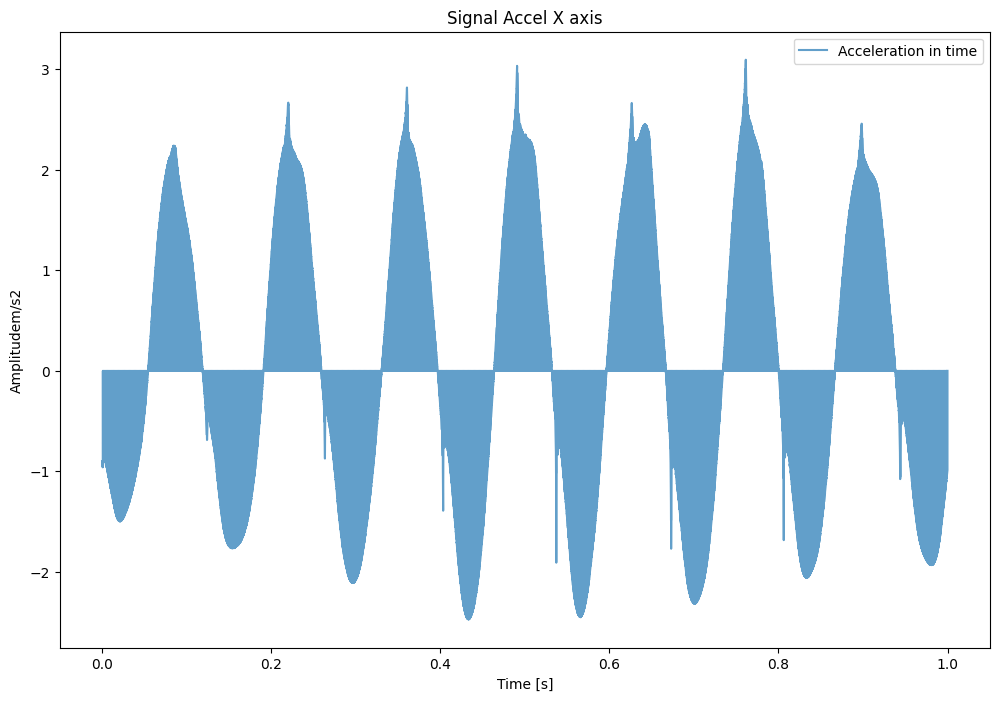

In [105]:
plot_Accel(accelValues, fs, start=19*fs,end=20*fs, measUnit="g")


In [99]:
from scipy.signal import spectrogram


def generateSpectrogram(signal, fs=50000, window='hamming', nperseg=1024, noverlap=512, scaling='density', title='Spectrogramme du signal audio'):
    
    # Calcul du spectrogramme
    frequencies, times, Sxx = spectrogram(signal, fs, window='hanning', nperseg=1024, noverlap=512, scaling='density')

    # Affichage du spectrogramme
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='plasma')
    plt.colorbar(label='Intensité (dB)')
    plt.title(title)
    plt.xlabel('Temps (s)')
    plt.ylabel('Fréquence (Hz)')
    plt.ylim(0, fs / 2)
    plt.show()

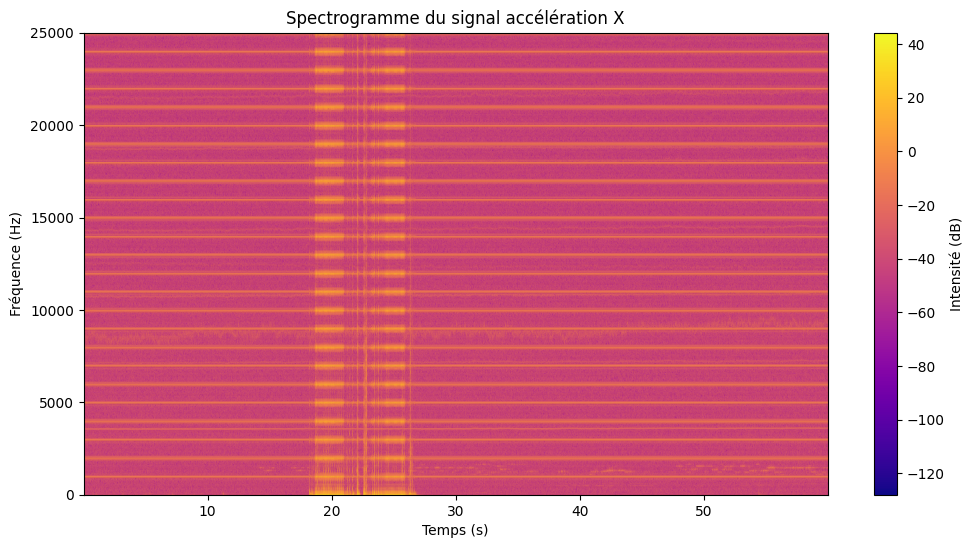

In [100]:
# Paramètres du signal
fs = 50000  # Fréquence d'échantillonnage (en Hz)
accel=accelXValues.copy()
generateSpectrogram(accel, fs=fs, title='Spectrogramme du signal accélération X')


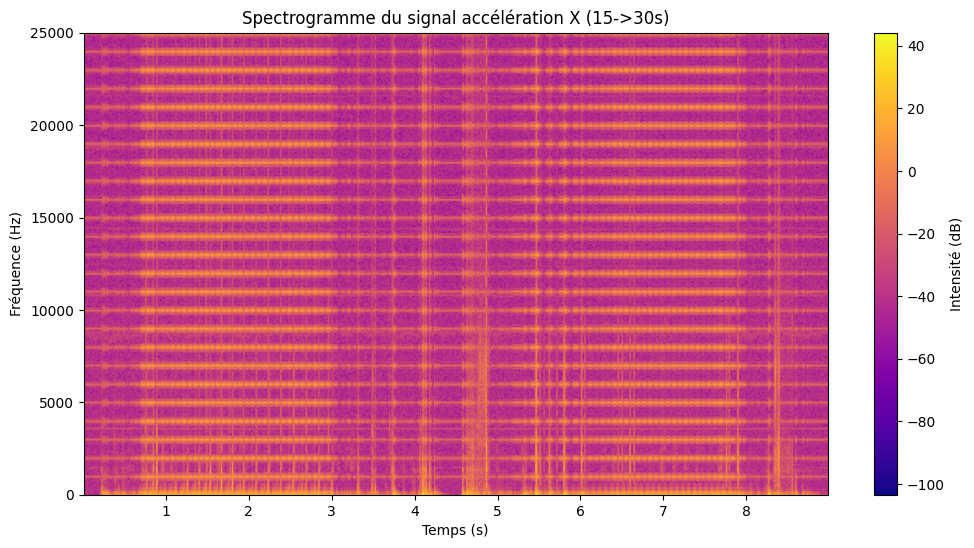

In [101]:
generateSpectrogram(accel[18*fs:27*fs], fs=fs, title='Spectrogramme du signal accélération X (15->30s)')


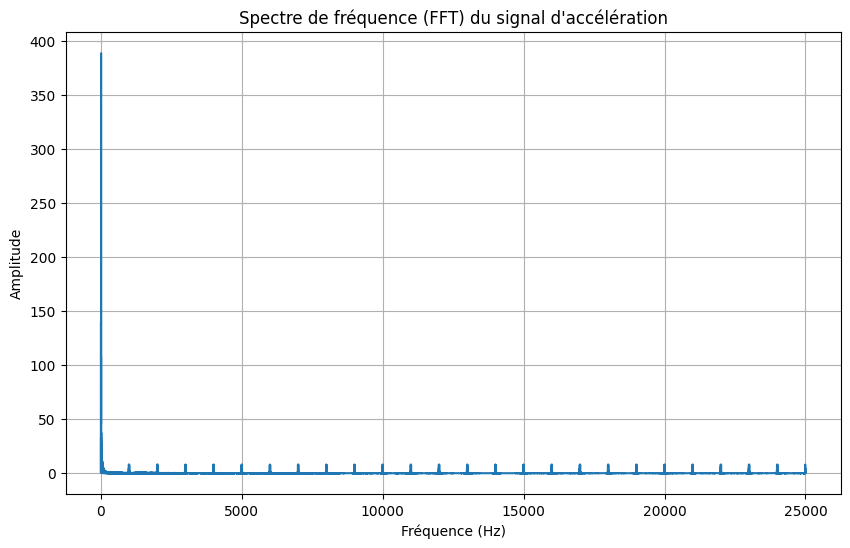

Primary frequencies : {} 7.111111111111111


In [96]:
from scipy.fft import fft, fftfreq

# FFT pour les fréquences principales
N = len(accel[18*fs:27*fs])
T = 1.0 / fs

# Calcul de la FFT
yf = fft(accel[18*fs:27*fs])
xf = fftfreq(N, T)[:N // 2]

# Calcul des amplitudes de la FFT
amplitudes = 2.0 / N * np.abs(yf[:N // 2])

# Tracé du spectre de la FFT
plt.figure(figsize=(10, 6))
plt.plot(xf, amplitudes)
plt.title("Spectre de fréquence (FFT) du signal d'accélération")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


primary_freq = xf[np.argmax(np.abs(yf[:N // 2]))]
print("Primary frequencies : {}", primary_freq)

### Analyze sound from recording


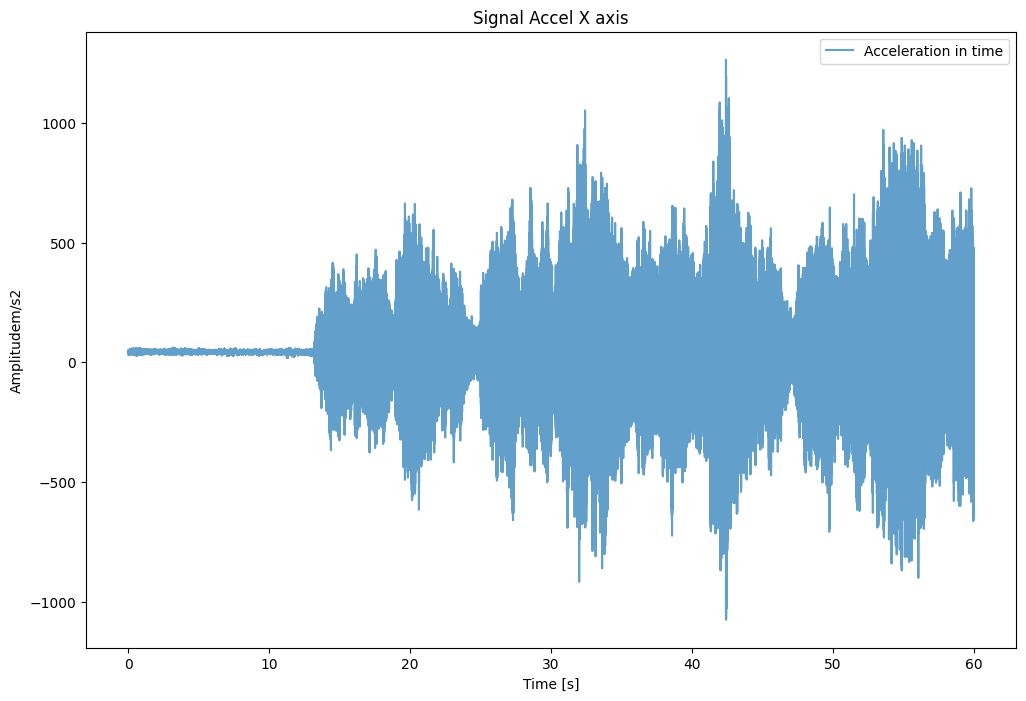

In [85]:
import sounddevice as sd
fs=50000
audio=soundValues.copy()

#Plot sound signal
plot_Accel(audio, fs, measUnit="??")
#audio = audio - np.mean(audio)  # Centrage
audio = np.int16(audio/np.max(np.abs(audio))*(2**15-1))  # Normalisation
# Start playback
sd.play(audio,samplerate=fs)
sd.wait()

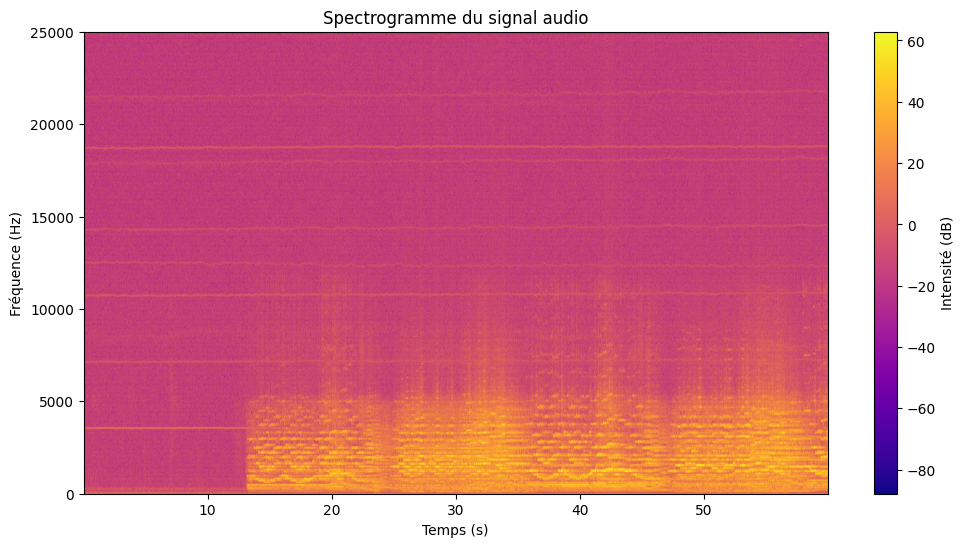

In [86]:
generateSpectrogram(audio, fs=fs)

In [51]:
from scipy.signal import firwin, lfilter, butter, filtfilt

# Paramètres du filtre FIR passe-bas
fs = 50000           # Fréquence d'échantillonnage
cutoff = 20000       # Fréquence de coupure à 20 kHz
numtaps = 101        # Nombre de coefficients du filtre (plus il est élevé, plus le filtre est précis)
order = 4           #Butterworth filtre IIR
# Conception du filtre passe-bas FIR
fir_coefficients = firwin(numtaps, cutoff / (fs / 2), window="hamming")
b, a = butter(order, cutoff / (fs / 2), btype='low')
# Application du filtre au signal
filtered_audio_fir = lfilter(fir_coefficients, 1.0, audio)
filter_audio_butter = filtfilt(b, a, audio)

print("Playing sound with FIR filter ...\n")
sd.play(filtered_audio_fir,samplerate=fs)
sd.wait()

print("Playing sound with Butterworth filter ...\n")
sd.play(filter_audio_butter,samplerate=fs)
sd.wait()



Playing sound with FIR filter ...
Playing sound with Butterworth filter ...


In [62]:
sd.play(audio,samplerate=fs)

In [87]:
import noisereduce as nr

# Réduction de bruit par profil de bruit sur les premières secondes
noise_profile = audio[:10*fs]  # Utiliser les premières secondes comme profil de bruit
reduced_noise_audio = nr.reduce_noise(y=audio, y_noise=noise_profile, sr=fs)
sd.play(reduced_noise_audio,samplerate=fs)
sd.wait()

C:\Users\Julie\AppData\Local\Temp\ipykernel_27048\179337174.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='plasma')


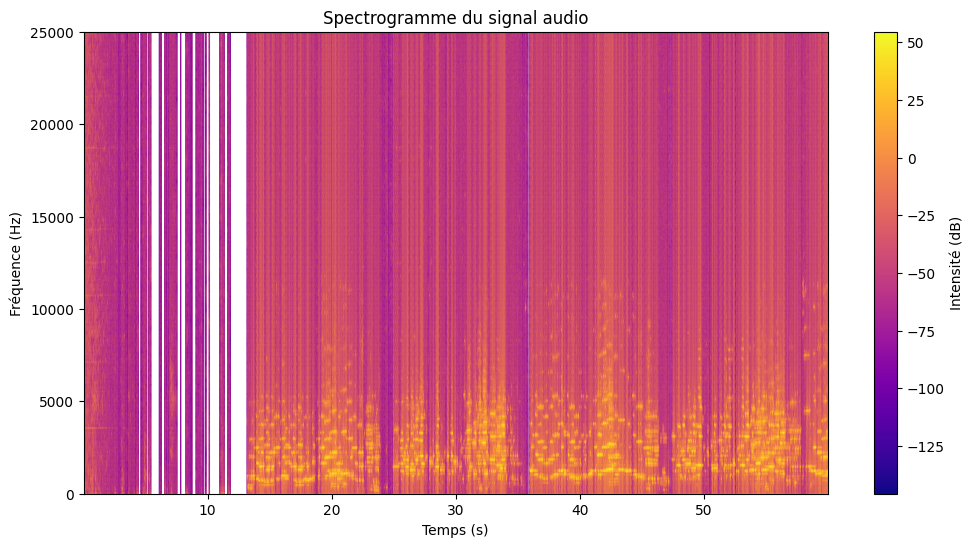

In [88]:
generateSpectrogram(reduced_noise_audio, fs=fs)

In [71]:
from scipy.io import wavfile

wavfile.write("../data/noiseReduced_Classical.wav", fs, reduced_noise_audio)

print("Fichier .wav enregistré avec succès.")

Fichier .wav enregistré avec succès.


In [98]:
sd.play(reduced_noise_audio,samplerate=fs)

In [97]:
sd.play(audio,samplerate=fs)

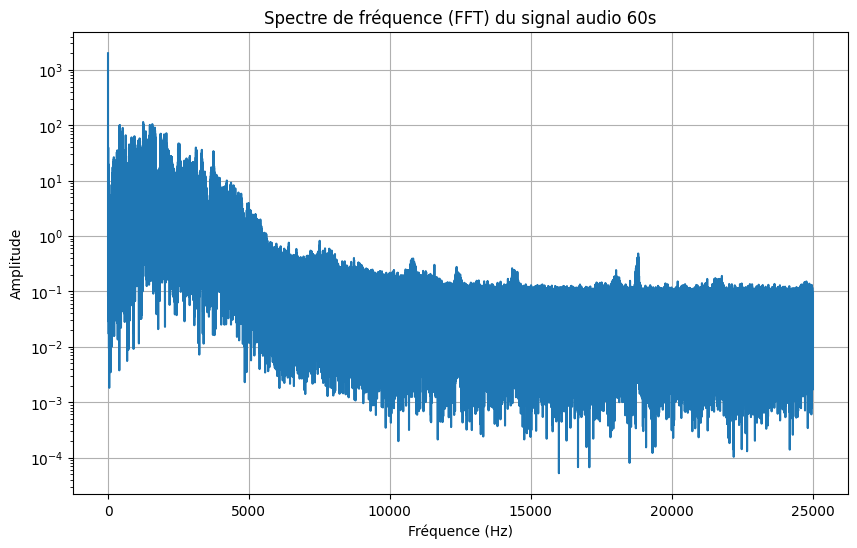

In [110]:
# FFT pour les fréquences principales
N = len(audio)
T = 1.0 / fs

# Calcul de la FFT
yf = fft(audio)
xf = fftfreq(N, T)[:N // 2]

# Calcul des amplitudes de la FFT
amplitudes = 2.0 / N * np.abs(yf[:N // 2])
#amplitudes = 10*np.log10(amplitudes)
# Tracé du spectre de la FFT
plt.figure(figsize=(10, 6))
plt.yscale('log', base=10)
plt.plot(xf, amplitudes)
plt.title("Spectre de fréquence (FFT) du signal audio 60s")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


primary_freq = xf[np.argmax(np.abs(yf[:N // 2]))]

In [107]:
print("Primary frequency : {}".format(primary_freq))


SyntaxError: invalid syntax (2919130401.py, line 1)